Reloading Tuner from cnn_bilstm_tuner/doge_forecast/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step

📊 Tuned CNN + BiLSTM R² Score (Base): 0.8996
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
📈 Final Residual-Enhanced R² Score: 0.9005


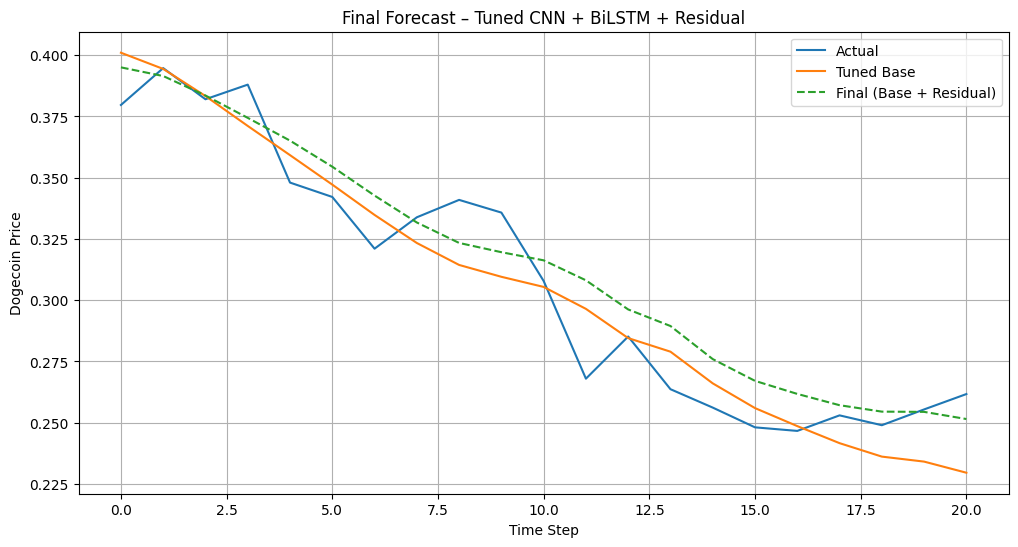

In [38]:
# ------------------------------
# Step 0: Install Keras Tuner (if not done)
# ------------------------------
# !pip install keras-tuner --upgrade

# ------------------------------
# Step 1: Imports
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Bidirectional, LSTM,
    Dropout, Dense, Input
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ------------------------------
# Step 2: Load Data & Feature Engineering
# ------------------------------
df = pd.read_csv('/content/Dogecoin_cleaned.csv')

df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True, errors='coerce')
df.dropna(subset=['Timestamp'], inplace=True)
df.set_index('Timestamp', inplace=True)

# Technical Indicators
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26

rolling_mean = df['Close'].rolling(window=20).mean()
rolling_std = df['Close'].rolling(window=20).std()
df['BB_upper'] = rolling_mean + (2 * rolling_std)
df['BB_lower'] = rolling_mean - (2 * rolling_std)

df['Price_Change_%'] = df['Close'].pct_change() * 100

if 'Volume' in df.columns:
    df['Volume'] = np.log1p(df['Volume'])

df.dropna(inplace=True)

# ------------------------------
# Step 3: Preprocessing & Sequence Creation
# ------------------------------
features = [
    'Close', 'EMA_10', 'EMA_30', 'RSI', 'MACD',
    'BB_upper', 'BB_lower', 'Price_Change_%'
]
if 'Volume' in df.columns:
    features.append('Volume')

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

true_close = df[['Close']].values
close_scaler = MinMaxScaler()
close_scaler.fit(true_close[sequence_length:])
y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# ------------------------------
# Step 4: Keras Tuner for Base Model
# ------------------------------
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Conv1D(
        filters=hp.Int('cnn_filters', 32, 128, step=16),
        kernel_size=hp.Choice('kernel_size', [2, 3, 4, 5]),
        activation='relu',
        padding='same'
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(
        hp.Int('lstm_units_1', 32, 128, step=16),
        return_sequences=True
    )))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)))
    model.add(Bidirectional(LSTM(
        hp.Int('lstm_units_2', 16, 64, step=16)
    )))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.3, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 5e-3, sampling='log')),
        loss='mse'
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='cnn_bilstm_tuner',
    project_name='doge_forecast'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(X_train, y_train, validation_data=(X_test, y_test),
             epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

# ------------------------------
# Step 5: Base Model Prediction
# ------------------------------
y_pred_base = best_model.predict(X_test)
y_pred_base_rescaled = close_scaler.inverse_transform(y_pred_base.reshape(-1, 1))

r2_base = r2_score(y_test_rescaled, y_pred_base_rescaled)
print(f"\n📊 Tuned CNN + BiLSTM R² Score (Base): {r2_base:.4f}")

# ------------------------------
# Step 6: Residual Model
# ------------------------------
residuals = y_test_rescaled.flatten() - y_pred_base_rescaled.flatten()

residual_model = Sequential()
residual_model.add(Input(shape=(X_test.shape[1], X_test.shape[2])))
residual_model.add(LSTM(64, return_sequences=True))
residual_model.add(Dropout(0.2))
residual_model.add(LSTM(32))
residual_model.add(Dropout(0.1))
residual_model.add(Dense(1))
residual_model.compile(optimizer='adam', loss='mse')

residual_model.fit(X_test, residuals, epochs=50, batch_size=32, verbose=0)

residual_preds = residual_model.predict(X_test)
final_pred = y_pred_base_rescaled.flatten() + residual_preds.flatten()

# ------------------------------
# Step 7: Final Evaluation
# ------------------------------
r2_final = r2_score(y_test_rescaled, final_pred)
print(f"📈 Final Residual-Enhanced R² Score: {r2_final:.4f}")

# ------------------------------
# Step 8: Plot Forecast
# ------------------------------
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_base_rescaled, label='Tuned Base')
plt.plot(final_pred, label='Final (Base + Residual)', linestyle='--')
plt.title("Final Forecast – Tuned CNN + BiLSTM + Residual")
plt.xlabel("Time Step")
plt.ylabel("Dogecoin Price")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# ============================
# Step 9: Save Both Models
# ============================

# Save the base model (Tuned CNN + BiLSTM)
best_model.save('/content/tuned_base_model.h5')

# Save the residual model
residual_model.save('/content/residual_model.h5')

print("✅ Models saved successfully!")


✅ Models saved successfully!
